# Emotion Classification
## DATASCI 281 - Computer Vision
### Students: Diego Moss, Subhasis Das, Priscilla Miller

## Import Libraries/Modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import preprocessing_functions as pf
from skimage.filters import gabor
import cv2
from skimage.feature import hog
import time


## Feature Extraction Functions

In [2]:
# feature extraction functions
# extract sobel edge
def sobel_edges(images_array):
    images_array = feature_preprocessing(images_array, norm=False, gray=True, contrast=False)
    n_images = images_array.shape[0]
    processed = np.zeros(images_array.shape[:3], dtype=np.uint8)
    for i in range(n_images):
        # histogram equalization
        img_eq = cv2.equalizeHist(images_array[i])
        
        # Apply Sobel edge detection
        # Sobel in X direction
        sobelx = cv2.Sobel(img_eq, cv2.CV_64F, 1, 0, ksize=5)
        # Sobel in Y direction
        sobely = cv2.Sobel(img_eq, cv2.CV_64F, 0, 1, ksize=5)
        # Combine both gradients
        sobel_combined = cv2.magnitude(sobelx, sobely)
        processed[i] = sobel_combined
    processed = processed.reshape(processed.shape[0], -1)
    return processed

# extract gabor
def compute_gabor(images, params={"theta": 90, "frequency": 0.2, "sigma": 2, "bandwidth": 0.5, "offset": np.pi}):
    
    images = feature_preprocessing(images, norm=False, gray=True, contrast=False)
    
    n_images = len(images)
    gabor_features = []
    
    for i in range(n_images):
        # Get current image
        image = images[i]

        # Apply Gabor filter
        response, gabor_image = gabor(image, 
                           frequency=params["frequency"], 
                           theta=np.deg2rad(params["theta"]),
                           sigma_x=params["sigma"], 
                           sigma_y=params["sigma"],
                           bandwidth=params["bandwidth"], 
                           offset=params["offset"])
        
        # Store features
        gabor_features.append(response.flatten())
    
    return np.array(gabor_features), gabor_image

# extract HOG
def extract_hog_features(images, orientations=18, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', channel=None):
    
    images = feature_preprocessing(images, norm=False, gray=True, contrast=False)
    
    n_samples = len(images)
    
    # Process first image to get feature dimensions
    fd = hog(images[0], 
             orientations=orientations,
             pixels_per_cell=pixels_per_cell,
             cells_per_block=cells_per_block,
             block_norm=block_norm,
             feature_vector=True,
             channel_axis=channel)
    
    # Initialize feature array
    features = np.zeros((n_samples, len(fd)))
    features[0] = fd
    
    # Process remaining images
    for i in range(1, n_samples):
        features[i] = hog(images[i],
                         orientations=orientations,
                         pixels_per_cell=pixels_per_cell,
                         cells_per_block=cells_per_block,
                         block_norm=block_norm,
                         feature_vector=True,
                         channel_axis=channel)
    
    return features

# Preprocessing function 
def feature_preprocessing(images, norm=False, gray=False, contrast=False):
    preprocessed_images = images
    if norm:
        preprocessed_images = pf.normalize_images(preprocessed_images)
    if gray:
        preprocessed_images = pf.convert_to_grayscale(preprocessed_images)
    if contrast:
        preprocessed_images = pf.apply_contrast_normalization(preprocessed_images)
    return preprocessed_images

## PCA Functions

In [3]:
# combine feature vectors and apply PCA function
def combine_and_run_pca(*feature_vectors, n_components=None):

    if len(feature_vectors) == 0:
        raise ValueError("At least one feature vector must be provided")
    
    # Ensure all inputs are numpy arrays
    feature_vectors = [np.asarray(fv) for fv in feature_vectors]
    
    # Check if all feature vectors have the same number of samples
    n_samples = feature_vectors[0].shape[0]
    for i, fv in enumerate(feature_vectors):
        if fv.shape[0] != n_samples:
            raise ValueError(f"Feature vector {i} has {fv.shape[0]} samples, but {n_samples} were expected")
    
    # Concatenate the feature vectors along the feature axis
    combined_features = np.hstack(feature_vectors)
    print(f"Combined feature shape: {combined_features.shape}")
    
    # Calculate total feature dimensions
    total_dims = sum(fv.shape[1] for fv in feature_vectors)
    print(f"Feature dimensions: {[fv.shape[1] for fv in feature_vectors]}, total: {total_dims}")
    
    # Initialize and fit PCA
    if n_components is None:
        n_components = min(combined_features.shape)
    
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(combined_features)
    
    return pca, transformed_data


# Plot explained variance
def plot_pca_explained_variance(pca, save_path=None, show_plot=True, figsize=(10, 6), dpi=300, features=None):

    fig, ax = plt.subplots(figsize=figsize)
    
    if features is not None:
        feature_string = " + ".join(str(x) for x in features)
        feature_string = " (" + feature_string + ")"
    else:
        feature_string = ""
        
    # Plot the cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
            linestyle='-', label=f'Cumulative Variance{feature_string}')
    
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Explained Variance')
    ax.set_title('PCA Explained Variance by Components')
    ax.legend(loc='lower right')
    ax.grid(True)
    
    # Add horizontal lines at common thresholds
    thresholds = [0.9, 0.95, 0.99]
    colors = ['r', 'g', 'b']

    for threshold, color in zip(thresholds, colors):
        ax.axhline(y=threshold, color=color, linestyle='-', alpha=0.3)

        # Find component number for this threshold
        if any(cumulative_variance >= threshold):
            components_needed = np.argmax(cumulative_variance >= threshold) + 1
            ax.annotate(f'{components_needed} components for {threshold*100}%',
                        xy=(components_needed, threshold),
                        xytext=(components_needed + 1, threshold + 0.02),
                        arrowprops=dict(arrowstyle='->'),
                        fontsize=9)
    
    plt.tight_layout()
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi)
    
    # Show the plot if requested
    if show_plot:
        plt.show()
    else:
        plt.close()
        
    return fig, ax


# remove components function
def remove_pca_components(pca_model, transformed_data, method='threshold', value=0.95):

    cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)
    
    if method == 'threshold':
        if not (0 < value <= 1):
            raise ValueError("Threshold value must be between 0 and 1")
        
        # Find how many components we need to reach the variance threshold
        if any(cumulative_variance >= value):
            n_components = np.argmax(cumulative_variance >= value) + 1
            variance_explained = cumulative_variance[n_components-1]
        else:
            n_components = len(pca_model.explained_variance_ratio_)
            variance_explained = cumulative_variance[-1]
            print(f"Warning: Cannot reach {value*100:.1f}% variance threshold. Using all {n_components} components.")
        
    elif method == 'components':
        value = int(value)
        if not (0 < value <= transformed_data.shape[1]):
            raise ValueError(f"Number of components must be between 1 and {transformed_data.shape[1]}")
        
        n_components = value
        variance_explained = cumulative_variance[n_components-1] if n_components <= len(cumulative_variance) else 1.0
        
    else:
        raise ValueError("Method must be 'threshold' or 'components'")
    
    # Extract only the required components
    reduced_data = transformed_data[:, :n_components]
    
    print(f"Selected {n_components} out of {transformed_data.shape[1]} components")
    print(f"Variance explained: {variance_explained:.4f} ({variance_explained*100:.2f}%)")
    print(f"Reduced data shape: {reduced_data.shape}")
    
    return reduced_data, n_components, variance_explained



## Load Dataset

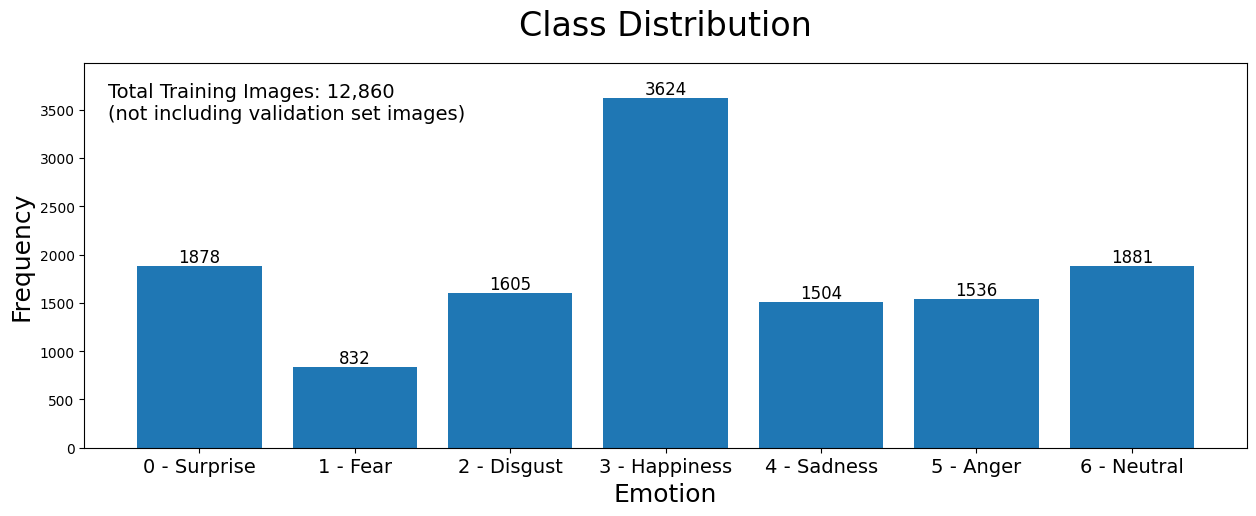

In [4]:
# load shuffled and denoised images
train_images, train_labels, val_images, val_labels, test_images, test_labels = utils.load_processed_data('all_augmented_preprocessed_data.pkl')

# label mapping
labels_dict = {0: 'surprise', 1: 'fear', 2: 'disgust', 3: 'happiness', 4: 'sadness', 5: 'anger', 6: 'neutral'}

# Adjust label values to be from 0 to 6
y_train = train_labels - 1
y_val = val_labels - 1
y_test = test_labels - 1

# Visualize distribution of training images
# Find unique value counts
unique, counts = np.unique(y_train, return_counts=True)
classes = [str(num) + " - " + labels_dict[num].title() for num in unique]
total_count = sum(counts)

# Create plot
plt.figure(figsize=(15, 5))
bars = plt.bar(range(len(counts)), counts)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Label/title plot
plt.title("Class Distribution", fontsize=24, y=1.05)
plt.xlabel("Emotion", fontsize=18)
plt.xticks(np.arange(len(counts)), classes, fontsize=14)
plt.ylabel("Frequency", fontsize=18)
plt.ylim(0, max(counts) * 1.1)
# Add total count as text annotation in upper right
plt.text(0.02, 0.95, f'Total Training Images: {total_count:,}\n(not including validation set images)', 
         transform=plt.gca().transAxes,
         ha='left', va='top',
         fontsize=14)

# Render plot
plt.show()

## Extract Features

In [5]:
# extract features
# training set
hog_features = extract_hog_features(train_images, channel=None)
gabor_features, _ = compute_gabor(train_images)
edge_features = sobel_edges(train_images)

# validation set
hog_features_val = extract_hog_features(val_images, channel=None)
gabor_features_val, _ = compute_gabor(val_images)
edge_features_val = sobel_edges(val_images)

# test set
hog_features_test = extract_hog_features(test_images, channel=None)
gabor_features_test, _ = compute_gabor(test_images)
edge_features_test = sobel_edges(test_images)

# normalize
gabor_features = gabor_features/255
edge_features = edge_features/255

gabor_features_val = gabor_features_val/255
edge_features_val = edge_features_val/255

gabor_features_test = gabor_features_test/255
edge_features_test = edge_features_test/255


### ResNet

In [6]:
# Normalize

resnet_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [C, H, W] and scales to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

def preprocess_array(img_array):
    if img_array.ndim == 2:  # Grayscale
        img_array = np.stack([img_array]*3, axis=-1)  # Convert to RGB
    img_array = img_array.astype(np.uint8)  # Make sure it's uint8 before ToTensor
    img_tensor = resnet_transform(img_array)  # Applies ToTensor and Normalize
    return img_tensor


if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Load ResNet and remove the classifier layer
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)
resnet_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet_extractor.eval()

def extract_features_batch(images):
    features = []
    with torch.no_grad():
        for img in images:
            x = preprocess_array(img).unsqueeze(0).to(device)  # (1, 3, H, W)
            feat = resnet_extractor(x).view(-1).cpu().numpy()  # (512,)
            features.append(feat)
    return np.stack(features)

resnet_feats = extract_features_batch(train_images)
resnet_val_feats = extract_features_batch(val_images)
resnet_test_feats = extract_features_batch(test_images)

## Run PCA and Remove Components

Combined feature shape: (12860, 19224)
Feature dimensions: [8712, 10000, 512], total: 19224
Transformed data shape: (12860, 12860)


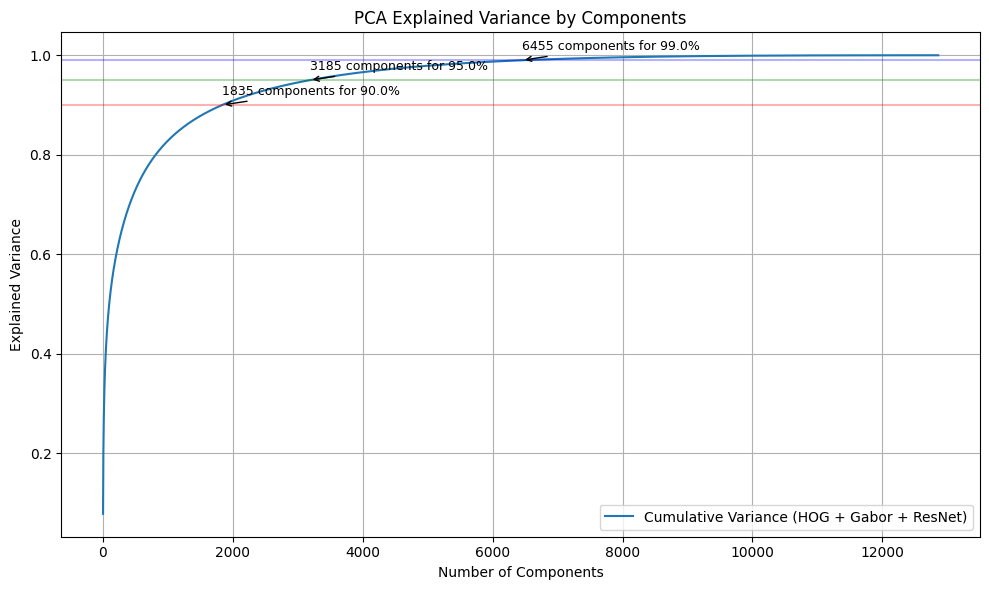

In [7]:
# Run PCA on combined features
pca_model, transformed_data = combine_and_run_pca(
    hog_features,
    #edge_features,
    gabor_features,
    resnet_feats
)

print(f"Transformed data shape: {transformed_data.shape}")
# Plot the explained variance
plot_pca_explained_variance(pca_model, save_path='pca_explained_variance.png', features=["HOG", "Gabor", "ResNet"]);

In [8]:
# remove unnecessary components 
threshold = 0.90
X_train, n_components, variance = remove_pca_components(
    pca_model, transformed_data, method='threshold', value=threshold
)

# Transform validation data using the existing PCA model
val_pca_transformed = pca_model.transform(np.hstack([
    hog_features_val,
    #edge_features_val,
    gabor_features_val,
    resnet_val_feats
]))

X_val, _, _ = remove_pca_components(
    pca_model, 
    val_pca_transformed, 
    method='threshold',  
    value=threshold           
)

# Transform test data using the existing PCA model
test_pca_transformed = pca_model.transform(np.hstack([
    hog_features_test,
    #edge_features_test,
    gabor_features_test,
    resnet_test_feats]))

X_test, _, _ = remove_pca_components(
    pca_model, 
    test_pca_transformed, 
    method='threshold',  
    value=threshold          
)

Selected 1835 out of 12860 components
Variance explained: 0.9000 (90.00%)
Reduced data shape: (12860, 1835)
Selected 1835 out of 12860 components
Variance explained: 0.9000 (90.00%)
Reduced data shape: (3068, 1835)
Selected 1835 out of 12860 components
Variance explained: 0.9000 (90.00%)
Reduced data shape: (3068, 1835)


## t-SNE

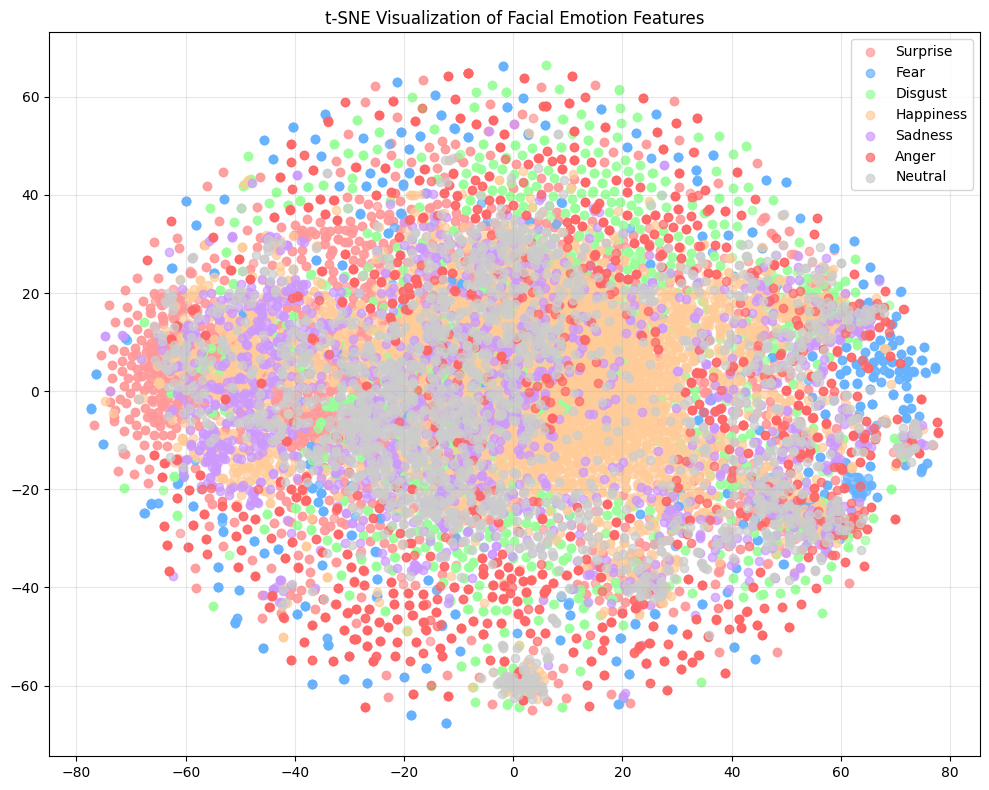

In [9]:
# tsne
# Apply t-SNE to the PCA-reduced features
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(X_train)

# Create scatter plot
plt.figure(figsize=(10, 8))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#CC99FF', '#FF6666', '#CCCCCC']

# Map each label in your dictionary to a color
for i, (label_num, emotion) in enumerate(labels_dict.items()):
    # Plot points for this emotion
    idx = np.where(y_train == label_num)[0]
    plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1], 
                c=colors[i % len(colors)], label=emotion.capitalize(), alpha=0.7)

plt.title('t-SNE Visualization of Facial Emotion Features')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_emotion_features.png', dpi=300)
plt.show()

## Check Shapes and Get Class Weights

In [10]:
# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of val labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

# Calculate class weights to correct for class imbalance
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


Shape of train images  (12860, 1835)
Shape of train labels  (12860,)
Shape of val images  (3068, 1835)
Shape of val labels  (3068,)
Shape of test images  (3068, 1835)
Shape of test labels  (3068,)


## Create Validation Subsets for Hyperparameters Search

In [11]:
# Create validation subsets for hyperparameter search
def create_val_subsets(val_x, val_y, n_subsets=3):
    val_x, val_y = shuffle(val_x, val_y, random_state=1234)
    subset_size = len(val_x) // n_subsets
    return [(val_x[d*subset_size:(d+1)*subset_size], val_y[d*subset_size:(d+1)*subset_size])
            for d in range(n_subsets)]

val_subsets = create_val_subsets(X_val, y_val, n_subsets=3)

## Neural Network Model

In [12]:
# Set seeds
torch.manual_seed(1234)
np.random.seed(1234)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend on Apple Silicon")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# Class weights (optional)
weight_list = [class_weights[i] for i in range(len(class_weights))]
class_weights_tensor = torch.tensor(weight_list, dtype=torch.float32).to(device)

def build_model(input_dim, hidden_units, dropout_rate):
    layers = []
    prev_units = input_dim
    for units in hidden_units:
        layers.append(nn.Linear(prev_units, units))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(units))
        layers.append(nn.Dropout(dropout_rate))
        prev_units = units
    layers.append(nn.Linear(prev_units, 7))  # output logits for 7 classes
    return nn.Sequential(*layers)

def train_one_model(model, train_loader, val_loader, learning_rate, weight_decay, class_weights, epochs=10, patience=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs} "
              f"| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered due to no val loss improvement.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
    return best_val_loss, best_val_acc


def evaluate_model(model, loader):
    model.eval()
    correct, total, total_loss = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            total_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return total_loss / total, correct / total


Using MPS backend on Apple Silicon


### Baseline (Neural Network)

In [13]:
baseline_model = build_model(input_dim=X_train.shape[1], hidden_units=[32], dropout_rate=0.1)

baseline_val_loss, baseline_val_acc = train_one_model(
    baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=0.01,
    weight_decay=0.0,
    class_weights=class_weights_tensor,
    epochs=3
)

print(f"\nBaseline validation accuracy: {baseline_val_acc:.2%}")
print(f"Baseline validation loss: {baseline_val_loss:.4f}")

Epoch 1/3 | Train Loss: 1.1668 | Train Acc: 0.5842 | Val Loss: 1.0177 | Val Acc: 0.6362
Epoch 2/3 | Train Loss: 0.6008 | Train Acc: 0.7844 | Val Loss: 1.0962 | Val Acc: 0.6281
Epoch 3/3 | Train Loss: 0.4231 | Train Acc: 0.8437 | Val Loss: 1.1854 | Val Acc: 0.6284

Baseline validation accuracy: 63.62%
Baseline validation loss: 1.0177


### Final Multi-Layer Perceptron (Neural Network) Model

#### Hyperparameter Search

In [14]:
param_dist = {
    'learning_rate': [1e-3, 1e-4],
    'dropout_rate': [0.3, 0.5],
    'l2_reg': [0.001, 0.01],
    'hidden_units': [(32,), (64, 32)]
}
param_list = list(ParameterSampler(param_dist, n_iter=16, random_state=1234))

best_score_acc = -np.inf
best_score_loss = float('inf')
best_params = None

for params in param_list:
    print(f"\nTesting: {params}")
    model = build_model(
        input_dim=X_train.shape[1],
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate']
    )
    best_val_loss, best_val_acc = train_one_model(
        model,
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=params['learning_rate'],
        weight_decay=params['l2_reg'],
        class_weights=class_weights_tensor,
        epochs=30
    )
    print(f"Best Val Loss: {best_val_loss:.4f} | Best Val Accuracy: {best_val_acc:.4f}")

    if (best_val_acc > best_score_acc) or \
       (best_val_acc == best_score_acc and best_val_loss < best_score_loss):
        best_score_acc = best_val_acc
        best_score_loss = best_val_loss
        best_params = params

print(f"\nBest validation accuracy: {best_score_acc:.4f}")
print(f"Corresponding validation loss: {best_score_loss:.4f}")
print(f"Best hyperparameters: {best_params}")



Testing: {'learning_rate': 0.001, 'l2_reg': 0.001, 'hidden_units': (32,), 'dropout_rate': 0.3}
Epoch 1/30 | Train Loss: 1.3922 | Train Acc: 0.5006 | Val Loss: 1.0723 | Val Acc: 0.6369
Epoch 2/30 | Train Loss: 0.8014 | Train Acc: 0.7369 | Val Loss: 0.9647 | Val Acc: 0.6565
Epoch 3/30 | Train Loss: 0.5918 | Train Acc: 0.8016 | Val Loss: 0.9791 | Val Acc: 0.6512
Epoch 4/30 | Train Loss: 0.4825 | Train Acc: 0.8351 | Val Loss: 1.0149 | Val Acc: 0.6565
Epoch 5/30 | Train Loss: 0.4097 | Train Acc: 0.8551 | Val Loss: 1.0646 | Val Acc: 0.6522
Early stopping triggered due to no val loss improvement.
Best Val Loss: 0.9647 | Best Val Accuracy: 0.6565

Testing: {'learning_rate': 0.0001, 'l2_reg': 0.001, 'hidden_units': (32,), 'dropout_rate': 0.3}
Epoch 1/30 | Train Loss: 1.9377 | Train Acc: 0.2209 | Val Loss: 1.7518 | Val Acc: 0.3657
Epoch 2/30 | Train Loss: 1.6012 | Train Acc: 0.4212 | Val Loss: 1.5456 | Val Acc: 0.4827
Epoch 3/30 | Train Loss: 1.3898 | Train Acc: 0.5315 | Val Loss: 1.4040 | Val 

#### Model Using Best Params

In [15]:
mlp_model = build_model(
    input_dim=X_train.shape[1],
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate']
)

start_time = time.time()

# Retrain on full training set
final_val_loss, final_val_acc = train_one_model(
    mlp_model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=best_params['learning_rate'],
    weight_decay=best_params['l2_reg'],
    class_weights=class_weights_tensor,
    epochs=30
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")


# Evaluate on test set
test_loss, test_acc = evaluate_model(mlp_model, test_loader)
print(f"\nFinal model validation accuracy: {final_val_acc:.2%}")
print(f"Final model test accuracy: {test_acc:.2%}")


Epoch 1/30 | Train Loss: 2.1134 | Train Acc: 0.1756 | Val Loss: 1.8271 | Val Acc: 0.3067
Epoch 2/30 | Train Loss: 1.9025 | Train Acc: 0.2425 | Val Loss: 1.7007 | Val Acc: 0.4175
Epoch 3/30 | Train Loss: 1.7656 | Train Acc: 0.3077 | Val Loss: 1.6101 | Val Acc: 0.4827
Epoch 4/30 | Train Loss: 1.6664 | Train Acc: 0.3627 | Val Loss: 1.5331 | Val Acc: 0.5186
Epoch 5/30 | Train Loss: 1.5712 | Train Acc: 0.4074 | Val Loss: 1.4578 | Val Acc: 0.5538
Epoch 6/30 | Train Loss: 1.4840 | Train Acc: 0.4560 | Val Loss: 1.4002 | Val Acc: 0.5870
Epoch 7/30 | Train Loss: 1.3915 | Train Acc: 0.5054 | Val Loss: 1.3500 | Val Acc: 0.6069
Epoch 8/30 | Train Loss: 1.3141 | Train Acc: 0.5417 | Val Loss: 1.2817 | Val Acc: 0.6271
Epoch 9/30 | Train Loss: 1.2489 | Train Acc: 0.5705 | Val Loss: 1.2301 | Val Acc: 0.6336
Epoch 10/30 | Train Loss: 1.1861 | Train Acc: 0.5954 | Val Loss: 1.1837 | Val Acc: 0.6431
Epoch 11/30 | Train Loss: 1.1168 | Train Acc: 0.6313 | Val Loss: 1.1367 | Val Acc: 0.6506
Epoch 12/30 | Train

F1 Score (Weighted): 0.6880


<Figure size 800x600 with 0 Axes>

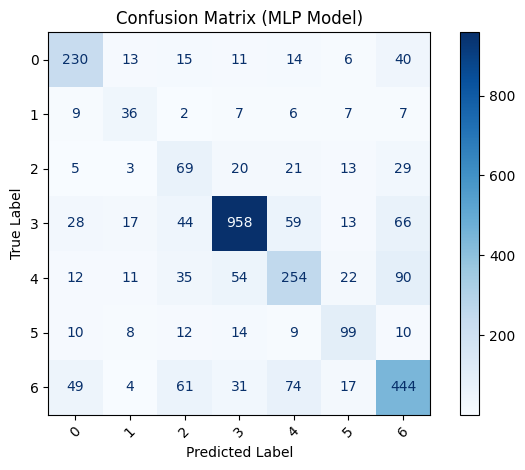

In [16]:
# Predict on test set
mlp_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        outputs = mlp_model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

y_test_pred = np.array(all_preds)

# Compute F1 scores
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.get_cmap('Blues'), xticks_rotation=45)
plt.title("Confusion Matrix (MLP Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()


#### ROC Curve for Neural Network

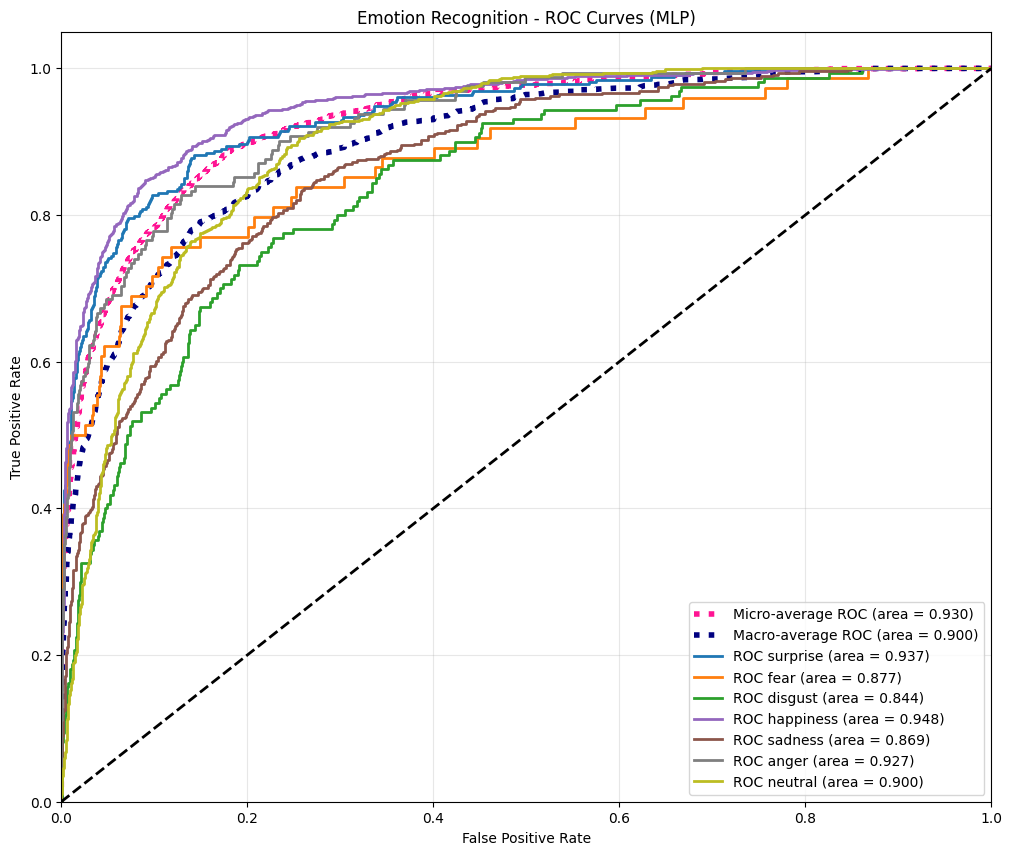

One-vs-Rest AUC scores:
surprise: 0.9366
fear: 0.8771
disgust: 0.8440
happiness: 0.9483
sadness: 0.8694
anger: 0.9265
neutral: 0.8996
Micro-average AUC: 0.9302
Macro-average AUC: 0.9004


In [17]:
# Set model to eval mode
mlp_model.eval()

# Get softmax probabilities on test set
y_test_probs = []
y_test_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = mlp_model(xb)
        probs = F.softmax(outputs, dim=1)  # Get predicted probabilities
        y_test_probs.append(probs.cpu().numpy())
        y_test_true.append(yb.cpu().numpy())

# Stack all batches
y_test_proba_mlp = np.vstack(y_test_probs)
y_test = np.concatenate(y_test_true)

# Binarize labels
n_classes = y_test_proba_mlp.shape[1]
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Compute FPR, TPR, and AUC
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba_mlp.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(12, 10))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC (area = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC (area = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=4)

cmap = plt.get_cmap('tab10')
for i in range(n_classes):
    color = cmap(i / n_classes)
    emotion_label = labels_dict[i]  # Assuming i maps to label
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {emotion_label} (area = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Emotion Recognition - ROC Curves (MLP)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUCs
print("One-vs-Rest AUC scores:")
for i in range(n_classes):
    emotion_label = labels_dict[i]
    print(f"{emotion_label}: {roc_auc[i]:.4f}")

print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")


## Logistic Regression

In [18]:
# Logistic Regression with 
# Define hyperparameter grid
C_values = [0.01, 0.1, 1]

best_score = -np.inf
best_params = None

# Manual grid search over 'C'
for C in C_values:
    print(f"\nTesting C = {C}")
    scores = []

    model = LogisticRegression(C=C, max_iter=5000, solver='sag', class_weight=class_weights)
    model.fit(X_train, y_train)

    # Track training accuracy
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    print(f"Training accuracy: {train_acc:.4f}")

    # Validation subset scores
    for X_val_sub, y_val_sub in val_subsets:
        y_pred = model.predict(X_val_sub)
        acc = accuracy_score(y_val_sub, y_pred)
        scores.append(acc)

    avg_score = np.mean(scores)
    print(f"Average val accuracy: {avg_score:.4f}")

    if avg_score > best_score:
        best_score = avg_score
        best_params = {'C': C}

# Final model training on full training set with best C
print(f"\nBest hyperparameters: {best_params}, accuracy: {best_score:.4f}")
lr = LogisticRegression(C=best_params['C'], max_iter=1000, solver='sag', class_weight=class_weights)


start_time = time.time()

lr.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

# Training accuracy
y_train_pred_lr = lr.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred_lr)
print(f"Training Accuracy: {train_acc:.4f}")

# Training accuracy
y_train_pred_lr = lr.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred_lr)
print(f"Training Accuracy: {train_acc:.4f}")



Testing C = 0.01
Training accuracy: 0.8994
Average val accuracy: 0.6601

Testing C = 0.1
Training accuracy: 0.9715
Average val accuracy: 0.6318

Testing C = 1
Training accuracy: 0.9986
Average val accuracy: 0.6135

Best hyperparameters: {'C': 0.01}, accuracy: 0.6601
Training time: 27.02 seconds
Training Accuracy: 0.8994
Training Accuracy: 0.8994


In [19]:
# Evaluate on validation and test sets
y_val_pred_lr = lr.predict(X_val)
y_test_pred_lr = lr.predict(X_test)

print("\nLogistic Regression Report (Validation):")
print(classification_report(y_val, y_val_pred_lr))

print("\nLogistic Regression Report (Test):")
print(classification_report(y_test, y_test_pred_lr))


Logistic Regression Report (Validation):
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       351
           1       0.32      0.45      0.38        73
           2       0.28      0.43      0.34       182
           3       0.89      0.80      0.84      1148
           4       0.57      0.55      0.56       478
           5       0.51      0.53      0.52       193
           6       0.64      0.59      0.61       643

    accuracy                           0.66      3068
   macro avg       0.55      0.58      0.56      3068
weighted avg       0.68      0.66      0.67      3068


Logistic Regression Report (Test):
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       329
           1       0.38      0.53      0.44        74
           2       0.32      0.49      0.39       160
           3       0.89      0.81      0.85      1185
           4       0.55      0.55      0.55       478


<Figure size 800x600 with 0 Axes>

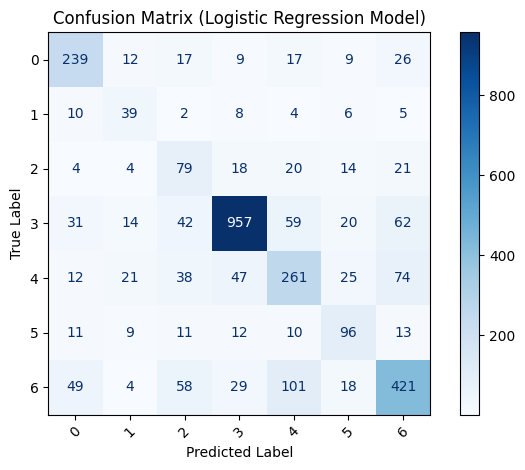

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.get_cmap('Blues'), xticks_rotation=45)
plt.title("Confusion Matrix (Logistic Regression Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

### ROC Curve for Logistic Regression Model

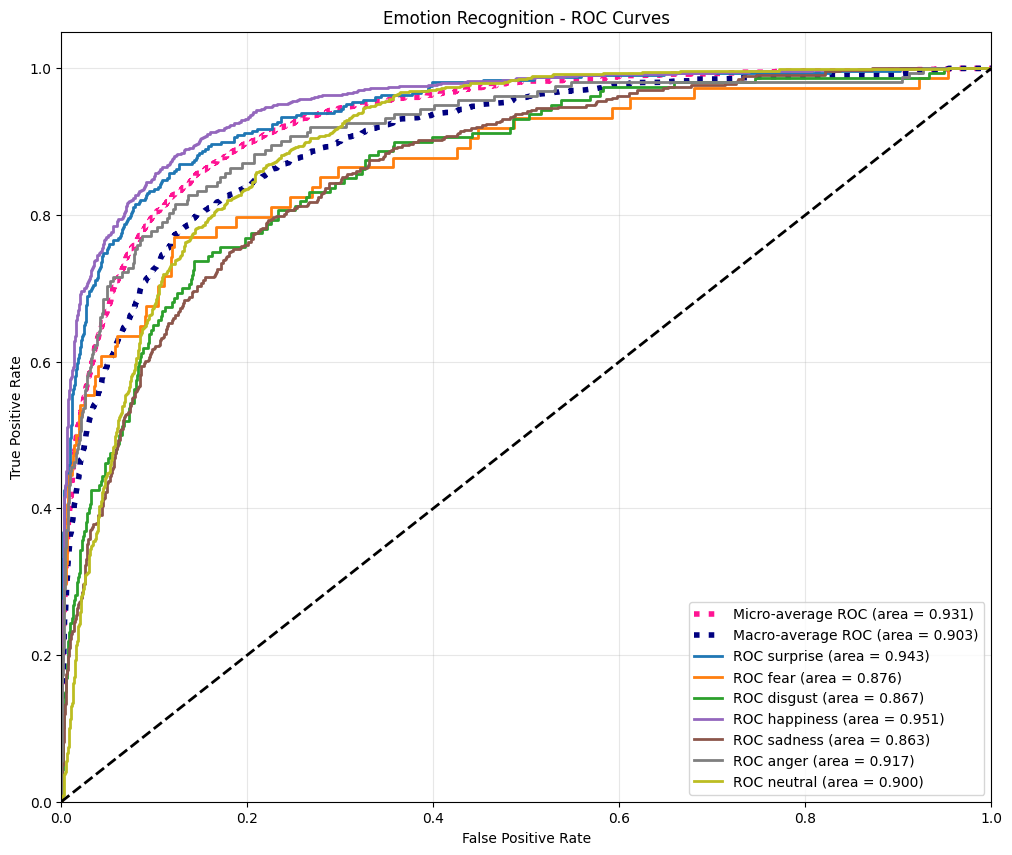

One-vs-Rest AUC scores:
surprise: 0.9433
fear: 0.8765
disgust: 0.8667
happiness: 0.9514
sadness: 0.8631
anger: 0.9172
neutral: 0.8997
Micro-average AUC: 0.9307
Macro-average AUC: 0.9028


In [21]:
# Get probability predictions
y_val_proba_lr = lr.predict_proba(X_val)
y_test_proba_lr = lr.predict_proba(X_test)

# Get the number of classes
n_classes = len(lr.classes_)

# Binarize the labels for one-vs-rest approach
y_val_bin = label_binarize(y_val, classes=lr.classes_)
y_test_bin = label_binarize(y_test, classes=lr.classes_)

# Initialize dictionaries to store FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_lr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba_lr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))

# Plot micro-average and macro-average ROC curves
plt.plot(fpr["micro"], tpr["micro"], 
         label=f'Micro-average ROC (area = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (area = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curves for each class
# Get color values from the colormap
cmap = plt.get_cmap('tab10')
for i in range(n_classes):
    color = cmap(i / n_classes)  # Get color from colormap
    # Use emotion label from dictionary instead of numeric class
    emotion_label = labels_dict[lr.classes_[i]]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {emotion_label} (area = {roc_auc[i]:.3f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Emotion Recognition - ROC Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUC scores for OvR approach with emotion labels
print("One-vs-Rest AUC scores:")
for i in range(n_classes):
    emotion_label = labels_dict[lr.classes_[i]]
    print(f"{emotion_label}: {roc_auc[i]:.4f}")

print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")

## SVM

In [22]:
# Define parameter grid
C_values = [0.01, 0.1, 1]
gamma_values = ['scale', 0.01, 0.001]
kernel = 'rbf'
class_weight = 'balanced'

# Track best config
best_score = -np.inf
best_params = None
results_list = []

# Manual search over hyperparameters
for C in C_values:
    for gamma in gamma_values:
        print(f"\nTesting C={C}, gamma={gamma}")

        model = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weight, probability=True)
        model.fit(X_train, y_train)

        # Evaluate on each validation subset
        val_scores = []
        for X_val_sub, y_val_sub in val_subsets:
            y_pred = model.predict(X_val_sub)
            acc = accuracy_score(y_val_sub, y_pred)
            val_scores.append(acc)

        avg_val_score = np.mean(val_scores)

        # Track training accuracy for comparison
        y_train_pred = model.predict(X_train)
        train_score = accuracy_score(y_train, y_train_pred)

        results_list.append({
            'C': C,
            'gamma': gamma,
            'train_accuracy': train_score,
            'avg_val_accuracy': avg_val_score
        })

        print(f"Train Acc: {train_score:.4f} | Avg Val Acc: {avg_val_score:.4f}")

        if avg_val_score > best_score:
            best_score = avg_val_score
            best_params = {'C': C, 'gamma': gamma}

# Save all results
results_df = pd.DataFrame(results_list)
results_df.to_csv("svm_manual_gridsearch_summary.csv", index=False)

print(f"\nBest hyperparameters: {best_params}, Avg Val Accuracy: {best_score:.4f}")

# Final model training on full training set with best params
best_svm = SVC(**best_params, kernel='rbf', class_weight='balanced', probability=True)

start_time = time.time()
best_svm.fit(X_train, y_train)  # or use np.concatenate([X_train, X_val]) if desired
end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

# Evaluation
y_train_pred = best_svm.predict(X_train)

print("\nSVM Report (Training):")
print(classification_report(y_train, y_train_pred))



Testing C=0.01, gamma=scale
Train Acc: 0.1589 | Avg Val Acc: 0.0923

Testing C=0.01, gamma=0.01
Train Acc: 0.1248 | Avg Val Acc: 0.0594

Testing C=0.01, gamma=0.001
Train Acc: 0.1321 | Avg Val Acc: 0.0662

Testing C=0.1, gamma=scale
Train Acc: 0.5766 | Avg Val Acc: 0.5238

Testing C=0.1, gamma=0.01
Train Acc: 0.1460 | Avg Val Acc: 0.1145

Testing C=0.1, gamma=0.001
Train Acc: 0.5322 | Avg Val Acc: 0.4817

Testing C=1, gamma=scale
Train Acc: 0.9381 | Avg Val Acc: 0.6908

Testing C=1, gamma=0.01
Train Acc: 1.0000 | Avg Val Acc: 0.2779

Testing C=1, gamma=0.001
Train Acc: 0.9600 | Avg Val Acc: 0.6853

Best hyperparameters: {'C': 1, 'gamma': 'scale'}, Avg Val Accuracy: 0.6908
Training time: 508.79 seconds

SVM Report (Training):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1878
           1       1.00      1.00      1.00       832
           2       0.90      0.98      0.94      1605
           3       0.98      0.89      0.93    


SVM Report (Validation):
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       351
           1       0.64      0.32      0.42        73
           2       0.32      0.48      0.38       182
           3       0.88      0.81      0.84      1148
           4       0.60      0.60      0.60       478
           5       0.59      0.58      0.58       193
           6       0.66      0.65      0.66       643

    accuracy                           0.69      3068
   macro avg       0.62      0.60      0.60      3068
weighted avg       0.71      0.69      0.70      3068


SVM Report (Test):
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       329
           1       0.60      0.47      0.53        74
           2       0.29      0.44      0.35       160
           3       0.86      0.80      0.83      1185
           4       0.59      0.56      0.57       478
           5       0.50      0.6

<Figure size 800x600 with 0 Axes>

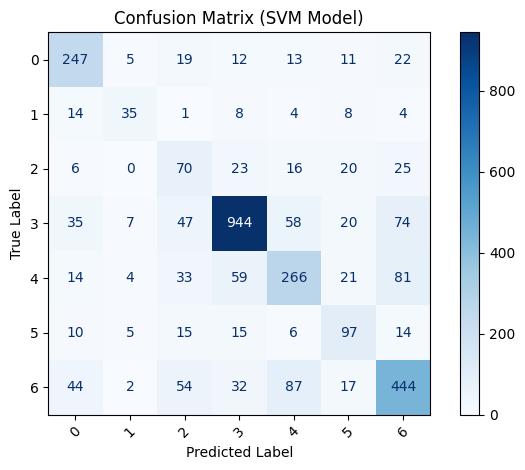

In [23]:
# Predict
y_val_pred = best_svm.predict(X_val)
y_test_pred = best_svm.predict(X_test)

print("\nSVM Report (Validation):")
print(classification_report(y_val, y_val_pred))

print("\nSVM Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.get_cmap('Blues'), xticks_rotation=45)
plt.title("Confusion Matrix (SVM Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.tight_layout()
plt.show()

### ROC Curve for SVM

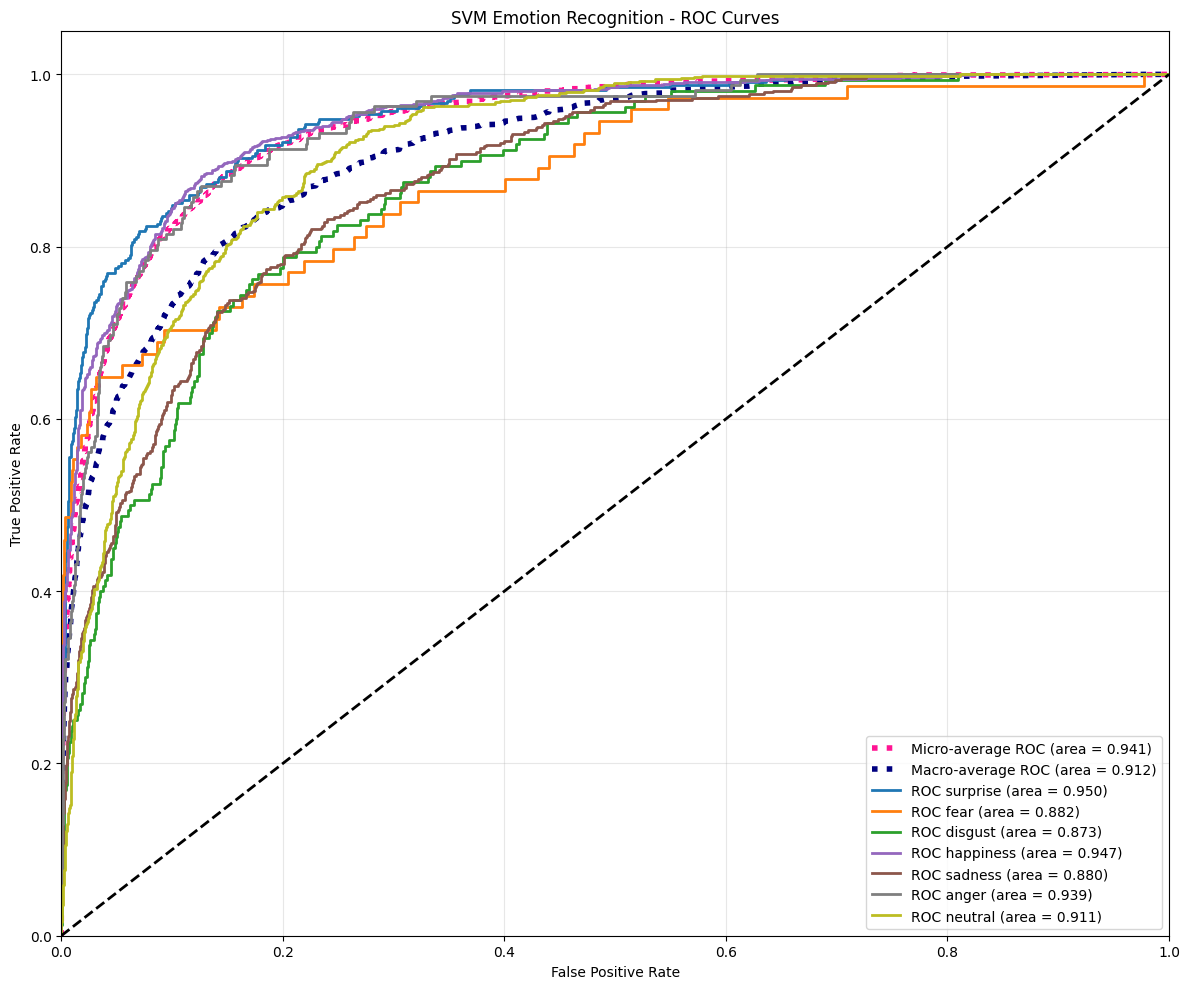

SVM One-vs-Rest AUC scores:
surprise: 0.9503
fear: 0.8820
disgust: 0.8728
happiness: 0.9469
sadness: 0.8799
anger: 0.9390
neutral: 0.9111
Micro-average AUC: 0.9414
Macro-average AUC: 0.9120


In [24]:

# Get probability predictions
y_val_proba_svm = best_svm.predict_proba(X_val)
y_test_proba_svm = best_svm.predict_proba(X_test)

# Number of classes
n_classes = len(best_svm.classes_)

# Binarize true labels for One-vs-Rest ROC
y_val_bin = label_binarize(y_val, classes=best_svm.classes_)
y_test_bin = label_binarize(y_test, classes=best_svm.classes_)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_proba_svm.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))

# Plot micro and macro
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (area = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC (area = {roc_auc["macro"]:.3f})',
         color='navy', linestyle=':', linewidth=4)

# Individual class ROC curves
cmap = plt.get_cmap('tab10')
for i in range(n_classes):
    color = cmap(i / n_classes)
    emotion_label = labels_dict[best_svm.classes_[i]]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {emotion_label} (area = {roc_auc[i]:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Emotion Recognition - ROC Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print per-class AUC
print("SVM One-vs-Rest AUC scores:")
for i in range(n_classes):
    emotion_label = labels_dict[best_svm.classes_[i]]
    print(f"{emotion_label}: {roc_auc[i]:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
